# EPUSP - Balanced hypergraph partitioning - v.12.2022

EPUSP - Balanced hypergraph partitioning - v.12.2022
Author: Waldemir Cambiucci
Data: Dec 29th, 2022

Description: translate benchmark circuit to hypergraph representation and make the partitioning in balanced layout, i.e., each partition with same number of qubits, with no optimization.


In [6]:
from collections import defaultdict

def decompose_edges_by_len(hypergraph):
    decomposed_edges = defaultdict(list)
    for edge in hypergraph['edges']:
        decomposed_edges[len(edge)].append(edge)
    decomposition = {
        'nodes': hypergraph['nodes'],
        'edges': decomposed_edges
    }
    return decomposition

In [7]:
import networkx as nx
from networkx import NetworkXException
import matplotlib.pyplot as plt

def plot_hypergraph_components(hypergraph):
    decomposed_graph = decompose_edges_by_len(hypergraph)
    decomposed_edges = decomposed_graph['edges']
    nodes = decomposed_graph['nodes']

    n_edge_lengths = len(decomposed_edges)
    
    # Setup multiplot style
    fig, axs = plt.subplots(1, n_edge_lengths, figsize=(5*n_edge_lengths, 5))
    if n_edge_lengths == 1:
        axs = [axs]  
    for ax in axs:
        ax.axis('off')
    fig.patch.set_facecolor('#003049')

    # For each edge order, make a star expansion (if != 2) and plot it
    for i, edge_order in enumerate(sorted(decomposed_edges)):
        edges = decomposed_edges[edge_order]
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        if edge_order == 2:
            g.add_edges_from(edges)
        else:
            for edge in edges:
                g.add_node(tuple(edge))
                for node in edge:
                    g.add_edge(node,tuple(edge))

        # ------------------------------------------
        # Trying with planar layout for the graph
        # ------------------------------------------
        try:
            pos = nx.planar_layout(g)            
        except NetworkXException:
            pos = nx.spring_layout(g)
        # ------------------------------------

        # Plot true nodes in orange, star-expansion edges in red
        extra_nodes = set(g.nodes) - set(nodes)
        nx.draw_networkx_nodes(g, pos, node_size=300, nodelist=nodes, 
                               ax=axs[i], node_color='#f77f00')
        nx.draw_networkx_nodes(g, pos, node_size=150, nodelist=extra_nodes, 
                               ax=axs[i], node_color='#d62828')
        nx.draw_networkx_edges(g, pos, ax=axs[i], edge_color='#eae2b7',
                               connectionstyle='arc3,rad=0.05', arrowstyle='-')

        # Draw labels only for true nodes
        labels = {node: str(node) for node in nodes}
        nx.draw_networkx_labels(g, pos, labels, ax=axs[i])

In [8]:
def get_vertices_from_gate(qasm_line):
    line_split = qasm_line.split("[")  
    tupla_str = str(line_split[1][0:1]) , str(line_split[2][0:1])
    return tupla_str

In [36]:
def convert_qasm_in_extended_hypergraph(qasm_str):  
    
    # creating the hypergraph from qasm
    hypergraph_from_qasm = {
    'nodes': [],
    'edges': [],
    'gates': []      
    }
    nqubits = 0
    # creating tuplas of 2-qubits gates in the circuit
    for line in qasm_str.splitlines():
        if any([line.startswith(t) for t in ['qreg']]):   
            pos = line.find('[') + 1
            nqubits = int(line[pos])
        
    # creating nodes/vertices for number of qubits
    for v in range(nqubits):
        hypergraph_from_qasm['nodes'].append(str(v))
    
    # creating tuplas of 2-qubits gates in the circuit
    for line in qasm_str.splitlines():
        
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            print(">> prelude: ", line)  
            
        elif line.startswith('cx'):            
            print(">> adding edges from cx - line: ", line)
            vertices_str = get_vertices_from_gate(line)
            hypergraph_from_qasm['edges'].append(vertices_str)
            hypergraph_from_qasm['gates'].append('cx')
            
        elif line.startswith('cz'):            
            print(">> adding edges from cx - line: ", line)
            vertices_str = get_vertices_from_gate(line)
            hypergraph_from_qasm['edges'].append(vertices_str)
            hypergraph_from_qasm['gates'].append('cz')
            
        elif line.startswith('swap'):            
            print(">> adding edges from cx - line: ", line)
            vertices_str = get_vertices_from_gate(line)
            hypergraph_from_qasm['edges'].append(vertices_str)    
            hypergraph_from_qasm['gates'].append('swap')
            
        else:
            print(">> ",line)
    
    print("\nReturning hypergraph created from OpenQasm.")
    return hypergraph_from_qasm 

In [27]:
def convert_qasm_in_hypergraph(qasm_str):  
    
    # creating the hypergraph from qasm
    hypergraph_from_qasm = {
    'nodes': [],
    'edges': []
    }
    nqubits = 0
    # creating tuplas of 2-qubits gates in the circuit
    for line in qasm_str.splitlines():
        if any([line.startswith(t) for t in ['qreg']]):   
            pos = line.find('[') + 1
            nqubits = int(line[pos])
        
    # creating nodes/vertices for number of qubits
    for v in range(nqubits):
        hypergraph_from_qasm['nodes'].append(str(v))
    
    # creating tuplas of 2-qubits gates in the circuit
    for line in qasm_str.splitlines():
        
        if any([line.startswith(t) for t in ['OPENQASM', 'include', 'qreg', 'creg']]):
            print(">> prelude: ", line)  
            
        elif line.startswith('cx'):            
            print(">> adding edges from cx - line: ", line)
            vertices_str = get_vertices_from_gate(line)
            hypergraph_from_qasm['edges'].append(vertices_str)
            
        elif line.startswith('cz'):            
            print(">> adding edges from cz - line: ", line)
            vertices_str = get_vertices_from_gate(line)
            hypergraph_from_qasm['edges'].append(vertices_str)
            
        elif line.startswith('swap'):            
            print(">> adding edges from swap - line: ", line)
            vertices_str = get_vertices_from_gate(line)
            hypergraph_from_qasm['edges'].append(vertices_str)    
            
        else:
            print(">> ",line)
    
    print("\nReturning hypergraph created from OpenQasm.")
    return hypergraph_from_qasm                

In [37]:
def extended_hypergraph_partition_by_connections(hypergraph,nparts):    
            
    print("Function: extended_hypergraph_partition_by_connections. Nodes, Edges, Gates")
    partitionsList=[]
    print(partitionsList)
    
    # creating the auxiliar hypergraph
    aux_hg = {
    'nodes': [],
    'edges': [],
    'gates': []
    }
    
    total_nodes = len(hypergraph['nodes'])
    total_edges = len(hypergraph['edges'])
    total_gates = len(hypergraph['gates'])
    balance_nodes = int(total_nodes / nparts)
    
    print("number of npart: ",nparts)
    print("number of nodes/vertices from monolitcal hypergraph: ",total_nodes)
    print("number of edges from monolitcal hypergraph: ",total_edges)
    print("number of nodes per segment: ",balance_nodes)

    # index for control of partitions
    w, h = 2, nparts
    index_partition = [[0 for x in range(w)] for y in range(h)] 

    for i in range(nparts):
        # initial index for the partition
        index_partition[i][0] = i*balance_nodes
        # final index for the partition
        index_partition[i][1] = index_partition[i][0] + balance_nodes - 1

    # repeat number of partition times
    for p in range(nparts):
        print("\ncreating segment " + str(p+1))
        
        # adding nodes for the segment p
        c = 0        
        for node in hypergraph['nodes']:
            if(c >= index_partition[p][0]) and (c <= index_partition[p][1]):
                aux_hg['nodes'].append(node)        
            c = c + 1

        # adding edges for the segment p
        for edge in hypergraph['edges']:
            aux_hg['edges'].append(edge)               
        
        # adding gates for the segment p
        for gate in hypergraph['gates']:
            aux_hg['gates'].append(gate)
            
        # record of sub-segment created
        print("\naux_hg: ", aux_hg)

        # saving the record sub-segment in the list
        partitionsList.append(aux_hg)    
        
        aux_hg = {
            'nodes': [],
            'edges': [],
            'gates': []
            }
        
    print("\nend of partition process.\n") 

    return partitionsList

In [28]:
def hypergraph_partition_by_connections(hypergraph,nparts):    
        
    print("Function: hypergraph_partition_by_connections. Nodes, Edges")
    partitionsList=[]
    print(partitionsList)
    
    # creating the auxiliar hypergraph
    aux_hg = {
    'nodes': [],
    'edges': []
    }
    
    total_nodes = len(hypergraph['nodes'])
    total_edges = len(hypergraph['edges'])
    balance_nodes = int(total_nodes / nparts)
    
    print("number of npart: ",nparts)
    print("number of nodes/vertices from monolitcal hypergraph: ",total_nodes)
    print("number of edges from monolitcal hypergraph: ",total_edges)
    print("number of nodes per segment: ",balance_nodes)

    # index for control of partitions
    w, h = 2, nparts
    index_partition = [[0 for x in range(w)] for y in range(h)] 

    for i in range(nparts):
        # initial index for the partition
        index_partition[i][0] = i*balance_nodes
        # final index for the partition
        index_partition[i][1] = index_partition[i][0] + balance_nodes - 1

    # repeat number of partition times
    for p in range(nparts):
        print("\ncreating segment " + str(p+1))
        
        # adding nodes for the segment p
        c = 0        
        for node in hypergraph['nodes']:
            if(c >= index_partition[p][0]) and (c <= index_partition[p][1]):
                aux_hg['nodes'].append(node)        
            c = c + 1

        # adding edges for the segment p
        for edge in hypergraph['edges']:
            aux_hg['edges'].append(edge)        
        
        # record of sub-segment created
        print("\naux_hg: ", aux_hg)

        # saving the record sub-segment in the list
        partitionsList.append(aux_hg)    
        
        aux_hg = {
            'nodes': [],
            'edges': []
            }
        
    print("\nend of partition process.\n") 

    return partitionsList

In [38]:
from qiskit import QuantumCircuit

# circuito Fig3 - arxiv.org/abs/2005.11614
# used with Pseudo code for Kernighan-Lin
qc_KL = QuantumCircuit(6)

qc_KL.cx(3,5)
qc_KL.barrier()

qc_KL.cz(2,1)
qc_KL.barrier()

qc_KL.cx(5,4)
qc_KL.barrier()

qc_KL.swap(1,3)
qc_KL.barrier()

qc_KL.cz(3,4)
qc_KL.barrier()

qc_KL.cx(0,1)
qc_KL.barrier()

qc_KL.draw()

░     ░       ░     ░     ░       ░ 
q_0: ──────░─────░───────░─────░─────░───■───░─
           ░     ░       ░     ░     ░ ┌─┴─┐ ░ 
q_1: ──────░──■──░───────░──X──░─────░─┤ X ├─░─
           ░  │  ░       ░  │  ░     ░ └───┘ ░ 
q_2: ──────░──■──░───────░──┼──░─────░───────░─
           ░     ░       ░  │  ░     ░       ░ 
q_3: ──■───░─────░───────░──X──░──■──░───────░─
       │   ░     ░ ┌───┐ ░     ░  │  ░       ░ 
q_4: ──┼───░─────░─┤ X ├─░─────░──■──░───────░─
     ┌─┴─┐ ░     ░ └─┬─┘ ░     ░     ░       ░ 
q_5: ┤ X ├─░─────░───■───░─────░─────░───────░─
     └───┘ ░     ░       ░     ░     ░       ░

In [39]:
qasm_str = qc_KL.qasm()
print(qasm_str)

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
cx q[3],q[5];
barrier q[0],q[1],q[2],q[3],q[4],q[5];
cz q[2],q[1];
barrier q[0],q[1],q[2],q[3],q[4],q[5];
cx q[5],q[4];
barrier q[0],q[1],q[2],q[3],q[4],q[5];
swap q[1],q[3];
barrier q[0],q[1],q[2],q[3],q[4],q[5];
cz q[3],q[4];
barrier q[0],q[1],q[2],q[3],q[4],q[5];
cx q[0],q[1];
barrier q[0],q[1],q[2],q[3],q[4],q[5];



In [40]:
qasm_hypergraph = convert_qasm_in_hypergraph(qasm_str)
print(qasm_hypergraph)

>> prelude:  OPENQASM 2.0;
>> prelude:  include "qelib1.inc";
>> prelude:  qreg q[6];
>> adding edges from cx - line:  cx q[3],q[5];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cz - line:  cz q[2],q[1];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cx - line:  cx q[5],q[4];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from swap - line:  swap q[1],q[3];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cz - line:  cz q[3],q[4];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cx - line:  cx q[0],q[1];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];

Returning hypergraph created from OpenQasm.
{'nodes': ['0', '1', '2', '3', '4', '5'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')]}


In [41]:
qasm_hypergraph = convert_qasm_in_extended_hypergraph(qasm_str)
print(qasm_hypergraph)

>> prelude:  OPENQASM 2.0;
>> prelude:  include "qelib1.inc";
>> prelude:  qreg q[6];
>> adding edges from cx - line:  cx q[3],q[5];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cx - line:  cz q[2],q[1];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cx - line:  cx q[5],q[4];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cx - line:  swap q[1],q[3];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cx - line:  cz q[3],q[4];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];
>> adding edges from cx - line:  cx q[0],q[1];
>>  barrier q[0],q[1],q[2],q[3],q[4],q[5];

Returning hypergraph created from OpenQasm.
{'nodes': ['0', '1', '2', '3', '4', '5'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')], 'gates': ['cx', 'cz', 'cx', 'swap', 'cz', 'cx']}


In [42]:
decompose_edges_by_len(qasm_hypergraph)

{'nodes': ['0', '1', '2', '3', '4', '5'],
 'edges': defaultdict(list,
             {2: [('3', '5'),
               ('2', '1'),
               ('5', '4'),
               ('1', '3'),
               ('3', '4'),
               ('0', '1')]})}

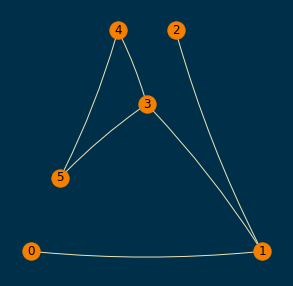

In [43]:
plot_hypergraph_components(qasm_hypergraph)

In [44]:
num_partition = 2
partitions = hypergraph_partition_by_connections(qasm_hypergraph,num_partition)

Function: hypergraph_partition_by_connections. Nodes, Edges
[]
number of npart:  2
number of nodes/vertices from monolitcal hypergraph:  6
number of edges from monolitcal hypergraph:  6
number of nodes per segment:  3

creating segment 1

aux_hg:  {'nodes': ['0', '1', '2'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')]}

creating segment 2

aux_hg:  {'nodes': ['3', '4', '5'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')]}

end of partition process.



In [45]:
num_partition = 2
partitions = extended_hypergraph_partition_by_connections(qasm_hypergraph,num_partition)

Function: extended_hypergraph_partition_by_connections. Nodes, Edges, Gates
[]
number of npart:  2
number of nodes/vertices from monolitcal hypergraph:  6
number of edges from monolitcal hypergraph:  6
number of nodes per segment:  3

creating segment 1

aux_hg:  {'nodes': ['0', '1', '2'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')], 'gates': ['cx', 'cz', 'cx', 'swap', 'cz', 'cx']}

creating segment 2

aux_hg:  {'nodes': ['3', '4', '5'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')], 'gates': ['cx', 'cz', 'cx', 'swap', 'cz', 'cx']}

end of partition process.




List of subsegments created during the partitioning process.

Sub-segment: 
{'nodes': ['0', '1', '2'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')], 'gates': ['cx', 'cz', 'cx', 'swap', 'cz', 'cx']}
Hypergraph for the sug-segment:

Sub-segment: 
{'nodes': ['3', '4', '5'], 'edges': [('3', '5'), ('2', '1'), ('5', '4'), ('1', '3'), ('3', '4'), ('0', '1')], 'gates': ['cx', 'cz', 'cx', 'swap', 'cz', 'cx']}
Hypergraph for the sug-segment:


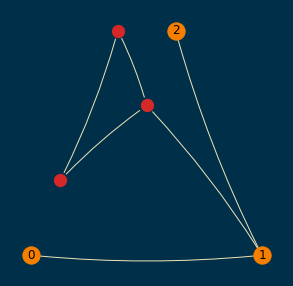

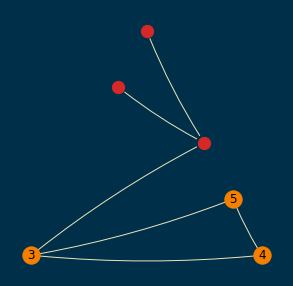

In [46]:
print("\nList of subsegments created during the partitioning process.")
for each in partitions:
    print("\nSub-segment: ")
    print(each)      
    
    print("Hypergraph for the sug-segment:")
    plot_hypergraph_components(each)

In [47]:
def valid_operation_for_this_segment(qasm_nodes,qubit1,qubit2):

    test1 = (str(qubit1) in qasm_nodes)
    test2 = (str(qubit2) in qasm_nodes)
    
    if (not test1) and (not test2):
        flag = False
    else: 
        flag = True
    
    return flag

In [48]:
from qiskit import QuantumCircuit, Aer, execute

def convert_extended_hypergraph_in_qasm(param_hg): 

    qasm_prelude = """OPENQASM 2.0;\ninclude "qelib1.inc";\n"""
    qasm_nodes = ""
    for node in param_hg['nodes']:
        qasm_nodes = qasm_nodes + "\t" + str(node)
    
    # adding correct number of qubits regs
    bigger_qubit = 0
    for edge in param_hg['edges']:
        if (bigger_qubit < int(edge[0])): 
            bigger_qubit = int(edge[0])
        elif (bigger_qubit < int(edge[1])): 
            bigger_qubit = int(edge[1])            
    qasm_qreg = "qreg q[" + str(bigger_qubit+1) + "];\n"
    
    # adding edges for the segment p
    i = 0
    qasm_circ = ""
    qasm_line = ""    
    for edge in param_hg['edges']:       
        qubit1 = edge[0]
        qubit2 = edge[1]
        gate = str(param_hg['gates'][i])       
        
        if ( valid_operation_for_this_segment(qasm_nodes,qubit1,qubit2) ):
            # creating the qasm line for the circuit
            qasm_line = gate + " q[" + qubit1 + "],q[" + qubit2 + "];\n"
            qasm_circ = qasm_circ + qasm_line
        
        i = i + 1

    # creating the qasm string
    qasm_str = qasm_prelude + qasm_qreg + qasm_circ
   
    return qasm_str

In [49]:
for each in partitions:    
    
    qc_qasm = convert_extended_hypergraph_in_qasm(each)

    print("Qasm file created:\n")
    print(qc_qasm)
    
    qc = QuantumCircuit.from_qasm_str(qc_qasm)

    print("Quantum circuit created:\n")
    print(qc)    

Qasm file created:

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
cz q[2],q[1];
swap q[1],q[3];
cx q[0],q[1];

Quantum circuit created:

                
q_0: ────────■──
           ┌─┴─┐
q_1: ─■──X─┤ X ├
      │  │ └───┘
q_2: ─■──┼──────
         │      
q_3: ────X──────
                
q_4: ───────────
                
q_5: ───────────
                
Qasm file created:

OPENQASM 2.0;
include "qelib1.inc";
qreg q[6];
cx q[3],q[5];
cx q[5],q[4];
swap q[1],q[3];
cz q[3],q[4];

Quantum circuit created:

                  
q_0: ─────────────
                  
q_1: ───────X─────
            │     
q_2: ───────┼─────
            │     
q_3: ──■────X───■─
       │  ┌───┐ │ 
q_4: ──┼──┤ X ├─■─
     ┌─┴─┐└─┬─┘   
q_5: ┤ X ├──■─────
     └───┘        


In [179]:
from qiskit.tools.visualization import plot_histogram

for each in partitions:
    
    qc_qasm = convert_extended_hypergraph_in_qasm(each)
    qc = QuantumCircuit.from_qasm_str(qc_qasm)    
    qc.measure_all()
    
    # You can choose other backend also.
    backend = Aer.get_backend("qasm_simulator")

    # Execute the circuit and show the result.
    job = execute(qc, backend,shots=1024)
    
    result = job.result()
    counts = result.get_counts()     

    print(counts)  
    print("\n")

    print(result)  
    print("\n")


{'000000': 1024}


Result(backend_name='qasm_simulator', backend_version='0.11.0', qobj_id='3d86d2e8-1065-453a-aab6-e3f2889cead1', job_id='4e88afec-47ba-4151-98e2-ae043c298157', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x0': 1024}), header=QobjExperimentHeader(clbit_labels=[['meas', 0], ['meas', 1], ['meas', 2], ['meas', 3], ['meas', 4], ['meas', 5]], creg_sizes=[['meas', 6]], global_phase=0.0, memory_slots=6, metadata={}, n_qubits=6, name='circuit-240', qreg_sizes=[['q', 6]], qubit_labels=[['q', 0], ['q', 1], ['q', 2], ['q', 3], ['q', 4], ['q', 5]]), status=DONE, seed_simulator=1966936380, metadata={'batched_shots_optimization': False, 'method': 'stabilizer', 'active_input_qubits': [0, 1, 2, 3, 4, 5], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 6, 'num_clbits': 6, 'sample_measure_time': 0.004461, 'input_qubit_map': [[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]], 'measure_sampling': True, 'noise': 